<a href="https://colab.research.google.com/github/rpdahxn/MakeYourFirstGANwithPyTorch/blob/main/08_gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset 

import pandas, numpy, random
import matplotlib.pyplot as plt

In [10]:
class MnistDataset(Dataset):

  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header = None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

    return label, image_values, target

  def plot_images(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title('label = ' + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation = 'none', cmap = 'Blues')
    pass

  pass

In [11]:
mnist_dataset = MnistDataset('/content/mount/MyDrive/Colab Notebooks/mnist_data/mnist_train.csv')

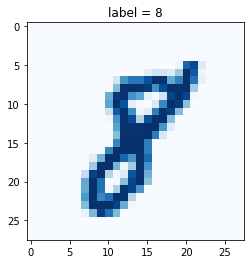

In [12]:
mnist_dataset.plot_images(17)

In [13]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [14]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

  pass

In [15]:
# 판별기 테스트
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  D.train(generate_random_image(784), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 13s, sys: 3.8 s, total: 4min 17s
Wall time: 4min 20s


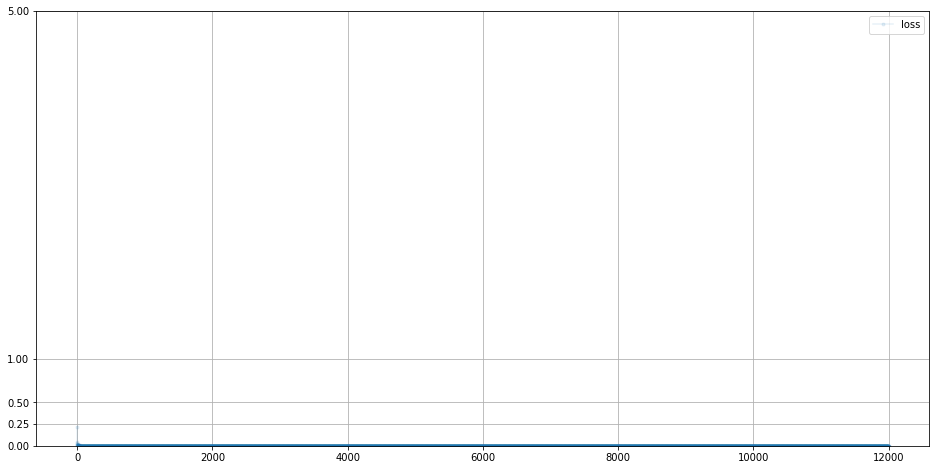

In [16]:
D.plot_progress()

In [17]:
# 가짜와 진짜를 판별할 수 있는지 판별기 직접 구동

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image(784)).item())
  pass

1.0
1.0
1.0
1.0
9.802525978430676e-12
8.799253860269918e-12
8.670404672006526e-12
9.115078483667993e-12


In [18]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  
  def forward(self, inputs):
    return self.model(inputs)


  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim = (0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

  pass

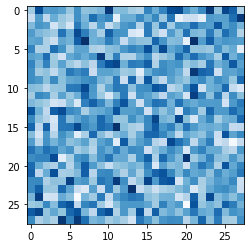

In [19]:
# 생성기의 출력이 올바른 타입과 형태를 지니고 있는지 확인

G = Generator()

output = G.forward(generate_random_seed(100))

img = output.detach().numpy().reshape(28, 28)

plt.imshow(img, interpolation = 'none', cmap = 'Blues')

**GAN 훈련**

In [24]:
%%time

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
  print("epoch = ", epoch + 1)


  # 판별기와 생성기 훈련
  for label, image_data_tensor, target_tensor in mnist_dataset:
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))  # G의 기울기는 계산되지 않도록 detach()

    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass


  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 29min 8s, sys: 24.3 s, total: 29min 32s
Wall time: 29min 34s


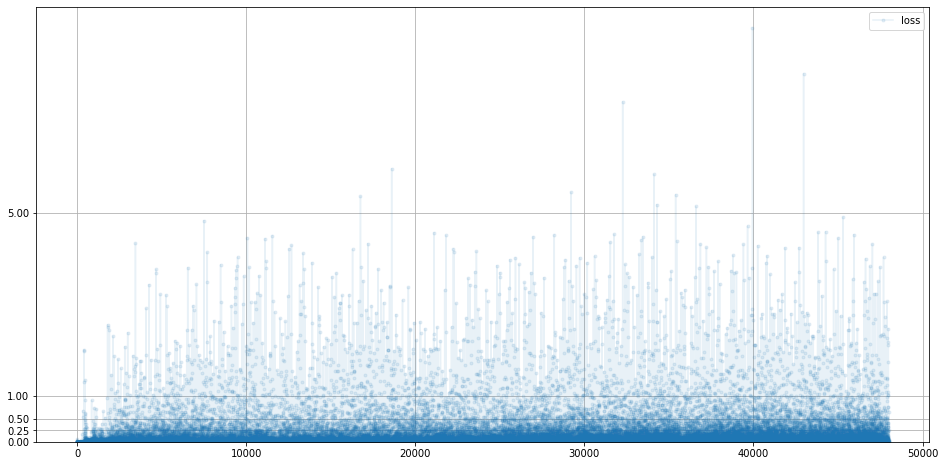

In [25]:
D.plot_progress()

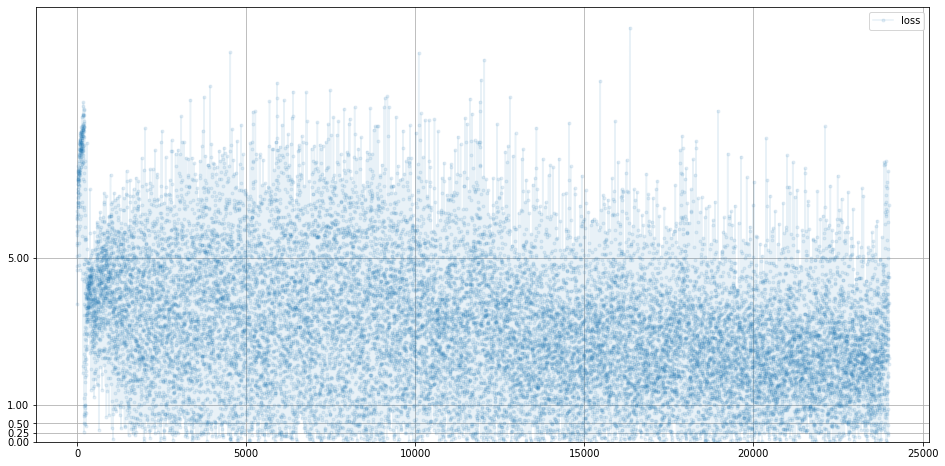

In [26]:
G.plot_progress()

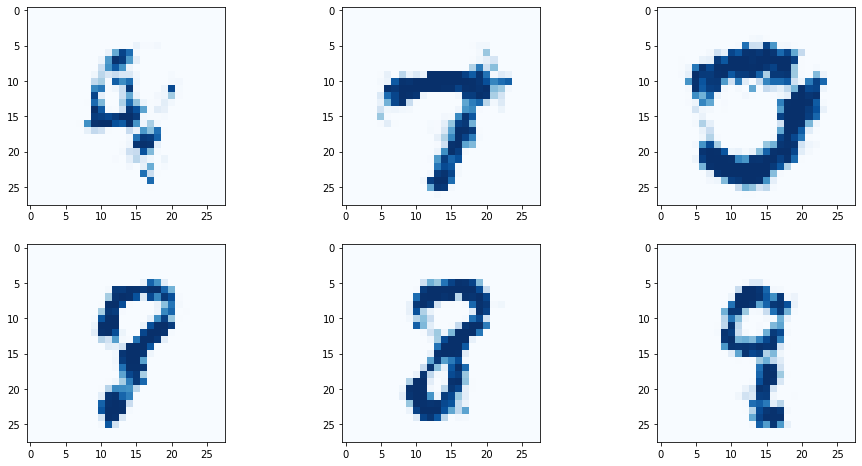

In [27]:
# 훈련된 생성기로부터 몇 개의 출력을 플롯해 본다.

f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation = 'none', cmap = 'Blues')
    pass
  pass